In [1]:
from selenium import webdriver 
from bs4 import BeautifulSoup
import re
import numpy as np
import csv
import pandas as pd
import json
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from collections import Counter
import statistics
import matplotlib.pyplot as plt
from sklearn import model_selection
%matplotlib inline

In [2]:
driver = webdriver.Chrome('C:/Users/Яна/chromedriver')

In [4]:
url='https://metrobook.ru/' # Получим список метро
driver.get(url)
html = driver.page_source
s = BeautifulSoup(html, 'lxml')
text=[]
for a_ in s.find_all('div', class_='stName'):
    se=re.findall(r'([0-9]+px|[А-Я]{1,}.?[()-.\s\d?[А-ЯЁ]{2,}]*)', str(a_))
    text.append(se)
    nda1=np.array(text)
df10 = pd.DataFrame(nda1, columns=['X', 'Y', 'Станция'])
df10.head(30)
df10['X']=df10['X'].str.replace('px','').astype(int)
df10['Y']=df10['Y'].str.replace('px','').astype(int)
df10['Станция']=df10['Станция'].str.replace('\n',' ')
df10['Станция'] = df10['Станция'].map(lambda x: x.capitalize().strip())
df11=df10[((df10['X'] >= 310) & (df10['X'] <= 1080)) & ((df10['Y'] <= 1060) & (df10['Y'] >= 400))]
df12=df10[(((df10['X'] <= 95) | (df10['X'] >= 1145))&(df10['Y'] <= 1800))|((df10['X'] <= 1410)&((df10['Y'] <= 156) | (df10['Y'] >= 1242)))]
I=set(df11['Станция'].tolist())
III=set(df12['Станция'].tolist())
vse=set(df10['Станция'].tolist())
II=vse-I-III
print(I)
print(II)

{'Киевская', 'Парк культуры', 'Кропоткинская', 'Серпуховская', 'Арбатская', 'Тверская', 'Таганская', 'Кузнецкий мост', 'Цветной бульвар', 'Краснопресненская', 'Чеховская', 'Красносельская', 'Беговая', 'Чкаловская', 'Александровский сад', 'Добрынинская', 'Пушкинская', 'Сухаревская', 'Комсомольская', 'Китай-город', 'Охотный ряд', 'Крестьянская застава', 'Новослободская', 'Лубянка', 'Баррикадная', 'Третьяковская', 'Новокузнецкая', 'Площадь революции', 'Сретенский бульвар', 'Трубная', 'Павелецкая', 'Смоленская', 'Маяковская', 'Чистые пруды', 'Курская', 'Октябрьская', 'Театральная', 'Марксистская', 'Тургеневская', 'Петровский парк', 'Фрунзенская', 'Динамо', 'Белорусская', 'Проспект мира', 'Боровицкая', 'Полянка', 'Хорошевская', 'Цска', 'Красные ворота', 'Библиотека им. ленина'}
{'Раменки', 'Спортивная', 'Тушинская', 'Кутузовская', 'Автозаводская', 'Ломоносовский проспект', 'Площадь гагарина', 'Ленинский проспект', 'Преображенская площадь', 'Водный стадион', 'Бульвар рокоссовского', 'Ростоки

In [5]:
df=pd.read_csv('sw_data_new.csv', delimiter=',',encoding='utf-8')
df=df[df['Время в пути'].notnull()] # убрали Nane  где нет времени до метро, их не так много
df=df[df['Тип жилья'].notnull()] # тоже мало,удалим
df = df.drop(df[df['Время в пути'].str.contains(' откроется в 2021') == True].index) 
df = df.drop(df[df['Время в пути'].str.contains(' откроется в 2019') == True].index)
df['Время в пути']=df['Время в пути'].str.replace('<1','0.5')
df1=df.copy(deep=True)
df1_part=df1[df1['Время в пути'] == df['Время в пути'].str.replace('мин. на транспорте','')]
df2=df.copy(deep=True)
df2_part=df2[df2['Время в пути'] == df['Время в пути'].str.replace('мин. пешком','')]
df1_part.loc[:, 'Время в пути'] = df1_part['Время в пути'].str.replace('мин. пешком','').astype(float)
df2_part.loc[:, 'Время в пути'] = df2_part['Время в пути'].str.replace('мин. на транспорте','').astype(float)*3 # на транспорте по статистике в 3 раза быстрее,чем пешком
df3 = pd.concat([df1_part, df2_part])
df3['Год'] = df3[['Срок сдачи',"Год постройки"]].max(axis =1)
df3.drop(df3.columns[[7,8]], axis = 1, inplace = True)
df3['Косметический'] = np.where(df3['Год'] < 2000,'Косметический', False)
df3['Наличие ремонта']=np.where(df3['Наличие ремонта'].isnull()==True, df3['Косметический'],df3['Наличие ремонта'])
df3['Наличие ремонта'] = df3['Наличие ремонта'].replace('False', 'Без ремонта')
df3.drop(df3.columns[[10]], axis = 1, inplace = True)
df3['Год новостойка'] = np.where(((df3['Тип жилья'] == 'Новостройка')|(df3['Тип жилья'] == 'Новостройка Апартаменты')),2021, False)
df3['Год']=np.where(df3['Год'].isnull()==True, df3['Год новостойка'],df3['Год'])
df3.drop(df3.columns[[10]], axis = 1, inplace = True)
df3["Тип дома"]=df3["Тип дома"].fillna(statistics.mode(df3["Тип дома"]))
df3['Общая площадь комнат']=df3['Общая площадь комнат'].astype(str).str.replace(',', '.').astype(float)
df3['Цена']=df3['Цена'].astype(str).str.replace('\\xa0', '').str.replace(r'\s+','',regex=True).astype(float)
df3['Год']=df3['Год'].astype(str).astype(float).astype(int)


counter1 = Counter()
for i in I:
    counter1[i] = 0

counter2 = Counter()
for i in II:
    counter2[i] = 1

counter3 = Counter()
for i in III:
    counter3[i] = 2

df3['Станция метро'] = df3['Станция метро'].map(lambda x: x.capitalize().strip())
df3['Станция метро'] = df3['Станция метро'].replace(counter1) 
df3['Станция метро'] = df3['Станция метро'].replace(counter2) 
df3['Станция метро'] = df3['Станция метро'].replace(counter3)
df3['Станция метро'].value_counts()

IV=set(df3['Станция метро'])-set([1,0,2])


counter4 = Counter()
for i in IV:
    counter4[i] = 0

df3['Станция метро'] = df3['Станция метро'].replace(counter4)
df3

,Тип жилья,Кол-во комнат,Станция метро,Время в пути,Этаж,Общая площадь комнат,Наличие ремонта,Тип дома,Цена,Год
0,Вторичка,5-комн,0,2.0,2,242.0,Дизайнерский,Кирпичный,177670080.0,1900
1,Вторичка,4-комн,0,14.0,3,216.7,Евроремонт,Кирпичный,104942640.0,1947
2,Вторичка,3-комн,0,5.0,8,105.9,Евроремонт,Монолитный,53000000.0,2000
4,Вторичка,4-комн,0,5.0,2,82.4,Косметический,Кирпичный,25500000.0,1938
5,Вторичка,2-комн,1,10.0,6,64.6,Косметический,Монолитный,11500000.0,1956
...,...,...,...,...,...,...,...,...,...,...
3006,Вторичка,1-комн,2,12.0,6,39.0,Косметический,Монолитный,7400000.0,1978
3011,Вторичка,3-комн,2,12.0,8,67.0,Косметический,Панельный,9150000.0,1973
3014,Новостройка,1-комн,2,15.0,18,47.0,Без ремонта,Монолитный,7950000.0,2021
3015,Вторичка,2-комн,2,15.0,4,52.0,Без ремонта,Панельный,7600000.0,1975


In [6]:
thresholds=[
    ('Время в пути', 31),
    ('Этаж',31),
    ('Общая площадь комнат', 280),
    ('Цена', 180000000),
]
def drop(df):
    thresholds=[
    ('Время в пути', 31),
    ('Этаж',31),
    ('Цена', 180000000),
]
    for column,t in thresholds:
        df=df.drop(df[df[column] >t].index)
    return df

df3=drop(df3)

thresholds=[
    ('Год', 0),
]
def drop(df):
    thresholds=[
    ('Год', 0),
]
    for column,t in thresholds:
        df=df.drop(df[df[column] == t].index)
    return df

df3=drop(df3)

thresholds=[
    ('Год', 1860),
]
def drop(df):
    thresholds=[
    ('Год', 1860),
]
    for column,t in thresholds:
        df=df.drop(df[df[column] <t].index)
    return df

df3=drop(df3)

In [7]:
categories=np.array(df3.values[:, [0,1,6,7]])
categories

array([['Вторичка', '5-комн', 'Дизайнерский', 'Кирпичный'],
       ['Вторичка', '4-комн', 'Евроремонт', 'Кирпичный'],
       ['Вторичка', '3-комн', 'Евроремонт', 'Монолитный'],
       ...,
       ['Вторичка', '3-комн', 'Косметический', 'Панельный'],
       ['Новостройка', '1-комн', 'Без ремонта', 'Монолитный'],
       ['Вторичка', '2-комн', 'Без ремонта', 'Панельный']], dtype=object)

In [8]:
enc = preprocessing.OneHotEncoder(sparse=False, categories='auto')
enc.fit(categories)
enc.transform(categories)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [9]:
df6=pd.get_dummies(df3, columns=['Тип жилья','Кол-во комнат','Наличие ремонта','Тип дома'])
df6

,Станция метро,Время в пути,Этаж,Общая площадь комнат,Цена,Год,Тип жилья_Вторичка,Тип жилья_Вторичка Апартаменты,Тип жилья_Вторичка Пентхаус,Тип жилья_Новостройка,...,Кол-во комнат_Студия,Наличие ремонта_Без ремонта,Наличие ремонта_Дизайнерский,Наличие ремонта_Евроремонт,Наличие ремонта_Косметический,Тип дома_Блочный,Тип дома_Кирпичный,Тип дома_Монолитно кирпичный,Тип дома_Монолитный,Тип дома_Панельный
0,0,2.0,2,242.0,177670080.0,1900,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,14.0,3,216.7,104942640.0,1947,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,5.0,8,105.9,53000000.0,2000,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,5.0,2,82.4,25500000.0,1938,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
5,1,10.0,6,64.6,11500000.0,1956,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,2,6.0,3,42.6,7535940.0,2021,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3006,2,12.0,6,39.0,7400000.0,1978,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3011,2,12.0,8,67.0,9150000.0,1973,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3014,2,15.0,18,47.0,7950000.0,2021,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [12]:
df6.drop(df6.columns[[4]], axis = 1, inplace = True)
df6

,Станция метро,Время в пути,Этаж,Общая площадь комнат,Тип жилья_Вторичка,Тип жилья_Вторичка Апартаменты,Тип жилья_Вторичка Пентхаус,Тип жилья_Новостройка,Тип жилья_Новостройка Апартаменты,Тип жилья_Новостройка Пентхаус,...,Кол-во комнат_Студия,Наличие ремонта_Без ремонта,Наличие ремонта_Дизайнерский,Наличие ремонта_Евроремонт,Наличие ремонта_Косметический,Тип дома_Блочный,Тип дома_Кирпичный,Тип дома_Монолитно кирпичный,Тип дома_Монолитный,Тип дома_Панельный
0,0,2.0,2,242.0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,14.0,3,216.7,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,5.0,8,105.9,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,5.0,2,82.4,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
5,1,10.0,6,64.6,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,2,6.0,3,42.6,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
3006,2,12.0,6,39.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3011,2,12.0,8,67.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3014,2,15.0,18,47.0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


In [10]:
df5 = df6.copy(deep=True)
df5

,Станция метро,Время в пути,Этаж,Общая площадь комнат,Цена,Год,Тип жилья_Вторичка,Тип жилья_Вторичка Апартаменты,Тип жилья_Вторичка Пентхаус,Тип жилья_Новостройка,...,Кол-во комнат_Студия,Наличие ремонта_Без ремонта,Наличие ремонта_Дизайнерский,Наличие ремонта_Евроремонт,Наличие ремонта_Косметический,Тип дома_Блочный,Тип дома_Кирпичный,Тип дома_Монолитно кирпичный,Тип дома_Монолитный,Тип дома_Панельный
0,0,2.0,2,242.0,177670080.0,1900,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,14.0,3,216.7,104942640.0,1947,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,5.0,8,105.9,53000000.0,2000,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,5.0,2,82.4,25500000.0,1938,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
5,1,10.0,6,64.6,11500000.0,1956,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,2,6.0,3,42.6,7535940.0,2021,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3006,2,12.0,6,39.0,7400000.0,1978,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3011,2,12.0,8,67.0,9150000.0,1973,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3014,2,15.0,18,47.0,7950000.0,2021,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


In [13]:
df_train,df_test = model_selection.train_test_split(np.array(df5))

In [14]:
X_train=np.delete(df_train, 4, axis=1)  
y_train=df_train[:,4]

In [15]:
X_test=np.delete(df_test, 4, axis=1) 
y_test=df_test[:,4]

In [16]:
# StandardScaler 
from sklearn.preprocessing import StandardScaler 
standartd_scaler2=preprocessing.StandardScaler()
standartd_scaler3=preprocessing.StandardScaler()
X_train_st=standartd_scaler2.fit_transform(X_train) 
y_train_st=standartd_scaler3.fit_transform(y_train.reshape(-1, 1))
X_test_st=standartd_scaler2.transform(X_test) 
y_test_st=standartd_scaler3.transform(y_test.reshape(-1, 1))


In [19]:
ridge=linear_model.Ridge(alpha=10.0)
model_selection.cross_val_score(
    ridge, 
    X_train_st, 
    y_train_st, 
    cv=5,
    scoring='neg_mean_squared_error'
).mean()

-0.25755392551055367

In [20]:
ridge.fit(X_train_st, y_train_st)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [21]:
predicts_test = ridge.predict(X_test_st)
predicts_train = ridge.predict(X_train_st)

In [22]:
from sklearn.metrics import mean_squared_error
ridge1=linear_model.Ridge(alpha=10.0)
ridge1.fit(X_train_st,y_train_st)
(*ridge1.coef_,ridge1.intercept_)
predicts_train1 = ridge1.predict(X_train_st)
print(mean_squared_error(y_train_st, predicts_train1))

0.2336859344273909


In [23]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_train_st, predicts_train))
print(mean_squared_error(y_test_st, predicts_test))

0.2336859344273909
0.2787429944077185


In [24]:
coefs_arr = np.array(sorted(list(zip(df6.columns,ridge1.coef_.reshape(-1, 1))),key=lambda x: -x[1]))
coefs_arr

array([['Общая площадь комнат', array([0.84949513])],
       ['Кол-во комнат_2-комн', array([0.09381812])],
       ['Наличие ремонта_Без ремонта', array([0.06152058])],
       ['Наличие ремонта_Евроремонт', array([0.04005082])],
       ['Кол-во комнат_3-комн', array([0.03375862])],
       ['Тип дома_Монолитный', array([0.02430751])],
       ['Кол-во комнат_Многокомнатная квартира', array([0.02430751])],
       ['Кол-во комнат_Квартира свободной планировки',
        array([0.02115778])],
       ['Тип жилья_Новостройка Апартаменты', array([0.0182714])],
       ['Тип жилья_Вторичка', array([0.01436137])],
       ['Тип дома_Панельный', array([0.01432312])],
       ['Тип дома_Блочный', array([0.00871684])],
       ['Наличие ремонта_Косметический', array([0.00730427])],
       ['Тип жилья_Вторичка Пентхаус', array([0.00241303])],
       ['Тип жилья_Новостройка', array([-0.00052043])],
       ['Время в пути', array([-0.00252015])],
       ['Тип жилья_Вторичка Апартаменты', array([-0.00370841]

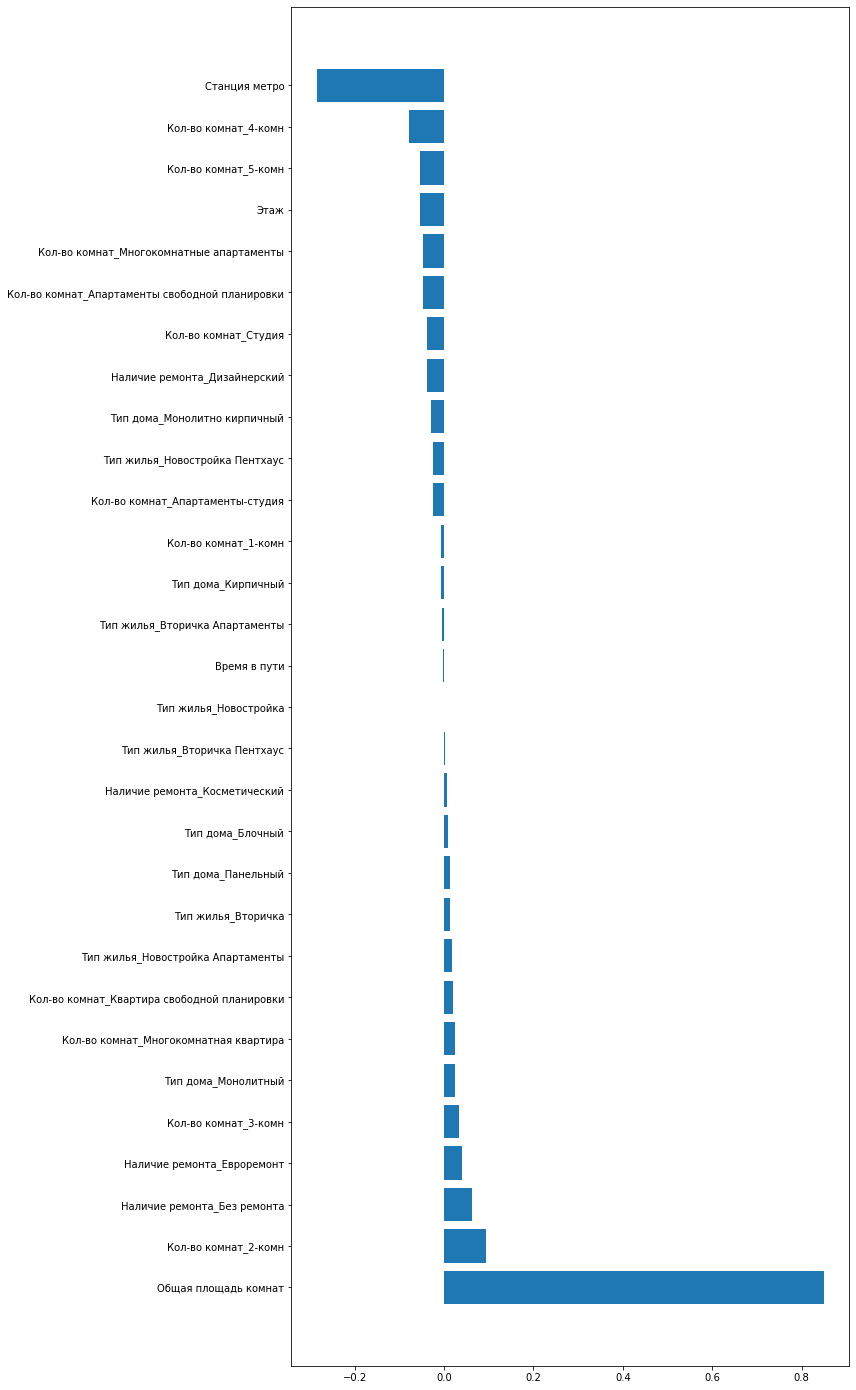

In [25]:
fig = plt.figure(figsize=[10, 25])
plt.barh(coefs_arr[:, 0], coefs_arr[:, 1].astype(float))
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X_train_st)


model = LinearRegression()
model.fit(x_poly, y_train_st)
y_poly_pred = model.predict(x_poly)

mse = mean_squared_error(y_train_st,y_poly_pred)
print(mse)

0.05096466385488294


In [27]:
x_poly_test = polynomial_features.fit_transform(X_test_st)
y_poly_pred_test = model.predict(x_poly_test)
mse = mean_squared_error(y_test_st,y_poly_pred_test)
print(mse)

4.35976042937713e+20


In [28]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    RandomForestClassifier,
    AdaBoostRegressor
)
import xgboost
from sklearn import ensemble

In [29]:
import itertools
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

In [30]:
import dataclasses

@dataclasses.dataclass(order=True)
class Data:
    neg_mean_squared_error:float
    max_depth: int 
    n_estimators: int 
    max_features:float
        
        
tree_params = {
    "max_depth": list(range(1, 7,1)),
    "n_estimators": list(range(1, 310,50)),
    "max_features": [0.9],
}
tree_params

all_tree_params = list(
    itertools.product(
        tree_params["max_depth"],
        tree_params["n_estimators"],
        tree_params["max_features"],
    )
)

results=[]

for (
    max_depth,
    n_estimators,
    max_features
) in all_tree_params:
    bagreg= BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),max_features=max_features, n_estimators=n_estimators)
    bagreg.fit(X_train_st, y_train_st.ravel())
    mse=metrics.mean_squared_error(y_test_st.ravel(), bagreg.predict(X_test_st))
    results.append(
        Data(
            model_selection.cross_val_score(
                bagreg,
                X_train_st,
                y_train_st.ravel(), 
                cv=10,
                scoring='neg_mean_squared_error'
            ).mean(),
            max_depth,
            n_estimators,
            max_features
        )
    )
results.sort(reverse=True)
print(results[0])

Data(neg_mean_squared_error=-0.18779522405814095, max_depth=6, n_estimators=201, max_features=0.9)


In [31]:
metrics.mean_squared_error(y_train_st, bagreg.predict(X_train_st))

0.09962034050844877

In [32]:
import dataclasses


@dataclasses.dataclass(order=True)
class Data1:
    mean_squared_error: float
    nthread: int
    max_depth: int
    subsample: float
    n_estimators: int
    learning_rate: float
    max_features: float
        
tree_params1 = {
    "nthread": [2,6],
    "max_depth": list(range(1, 7,1)),
    "subsample": [0.1,1.0],
    "n_estimators": list(range(1, 100,50)),
    "learning_rate": [0.1, 0.9],
    "max_features": [0.9],
}
tree_params1

all_tree_params = list(
    itertools.product(
        tree_params1["nthread"],
        tree_params1["max_depth"],
        tree_params1["subsample"],
        tree_params1["n_estimators"],
        tree_params1["learning_rate"],
        tree_params1["max_features"],
    )
)

results1 = []
np.random.seed(3)

for (
    nthread,
    max_depth,
    subsample,
    n_estimators,
    learning_rate,
    max_features
) in all_tree_params:
    xgb = xgboost.XGBRegressor(
        nthread=nthread,
        max_depth=max_depth,
        subsample=subsample,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_features=max_features
    )
    xgb.fit(X_train_st, y_train_st)
    results1.append(
        Data1(
            model_selection.cross_val_score(
                xgb,
                X_train_st,
                y_train_st, 
                cv=10,
                scoring='neg_mean_squared_error'
            ).mean(),            
            nthread,
            max_depth,
            subsample,
            n_estimators,
            learning_rate,
            max_features
        )
    )
results1.sort(reverse=True)
print(results1[0])

Data1(mean_squared_error=-0.1701840973098929, nthread=6, max_depth=6, subsample=1.0, n_estimators=51, learning_rate=0.1, max_features=0.9)


In [33]:
coefs_arr = np.array(sorted(list(zip(df6.columns,xgb.feature_importances_.reshape(-1, 1))),key=lambda x: -x[1]))
coefs_arr

array([['Общая площадь комнат', array([0.22154404], dtype=float32)],
       ['Тип жилья_Новостройка Пентхаус',
        array([0.17334384], dtype=float32)],
       ['Станция метро', array([0.13068552], dtype=float32)],
       ['Кол-во комнат_3-комн', array([0.06867561], dtype=float32)],
       ['Тип дома_Монолитно кирпичный',
        array([0.05900786], dtype=float32)],
       ['Кол-во комнат_Многокомнатные апартаменты',
        array([0.05425117], dtype=float32)],
       ['Тип жилья_Новостройка Апартаменты',
        array([0.04917967], dtype=float32)],
       ['Наличие ремонта_Евроремонт', array([0.0333628], dtype=float32)],
       ['Тип дома_Кирпичный', array([0.02876905], dtype=float32)],
       ['Тип жилья_Новостройка', array([0.02566615], dtype=float32)],
       ['Кол-во комнат_4-комн', array([0.01964946], dtype=float32)],
       ['Тип жилья_Вторичка', array([0.01693728], dtype=float32)],
       ['Время в пути', array([0.0153477], dtype=float32)],
       ['Кол-во комнат_5-комн', ar

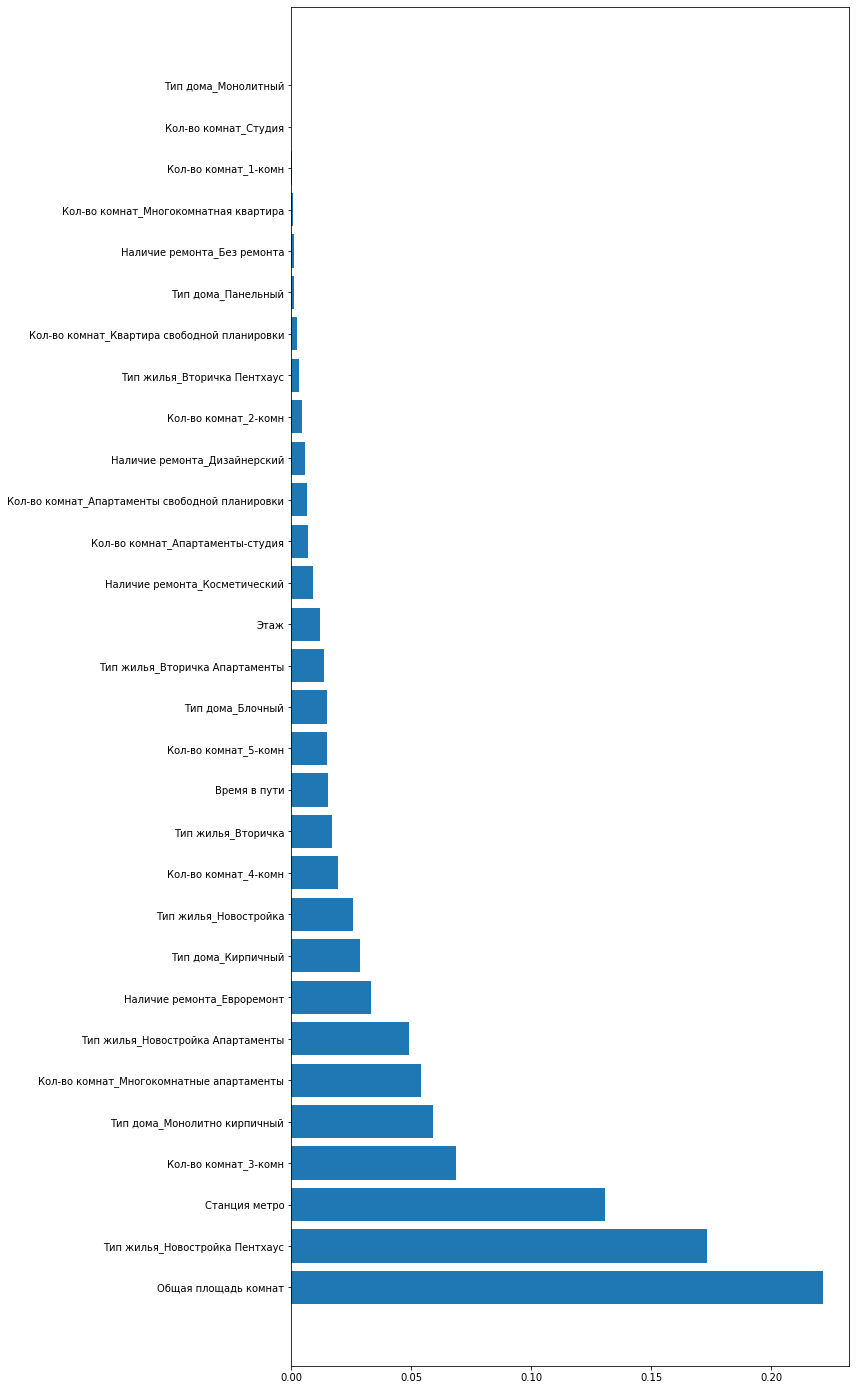

In [35]:
fig = plt.figure(figsize=[10, 25])
plt.barh(coefs_arr[:, 0], coefs_arr[:, 1].astype(float))
plt.show()

In [34]:
metrics.mean_squared_error(y_train_st, xgb.predict(X_train_st))

0.000935031056988673

In [36]:
import dataclasses


@dataclasses.dataclass(order=True)
class Data2:
    neg_mean_squared_error: float
    max_depth: int
    n_estimators: int
    min_samples_split: float
    max_features: float
        
tree_params2 = {
    "max_depth": list(range(1, 4,1)),
    "n_estimators": list(range(1, 62,10)),
    "min_samples_split": [1.0, 2, 3],
    "max_features": [0.8],
}
tree_params2

all_tree_params2 = list(
    itertools.product(
        tree_params2["max_depth"],
        tree_params2["n_estimators"],
        tree_params2["min_samples_split"],
        tree_params2["max_features"],
    )
)

results2 = []
np.random.seed(3)

for (
    max_depth,
    n_estimators,
    min_samples_split,
    max_features
) in all_tree_params2:
    rf = ensemble.RandomForestRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features
    )
    rf.fit(X_train_st, y_train_st.ravel())
    results2.append(
        Data2(
            model_selection.cross_val_score(
                xgb,
                X_train_st,
                y_train_st, 
                cv=10,
                scoring='neg_mean_squared_error'
            ).mean(),
            max_depth,
            n_estimators,
            min_samples_split,
            max_features
        )
    )
results2.sort(reverse=True)
print(results2[0])

Data2(neg_mean_squared_error=-0.2253686182894839, max_depth=3, n_estimators=61, min_samples_split=3, max_features=0.8)


In [37]:
metrics.mean_squared_error(y_train_st, rf.predict(X_train_st))

0.20286403607412318

In [39]:
import joblib

with open('project.joblib', "wb") as file:
    joblib.dump(xgb, file)

with open('enc.joblib', "wb") as file:
    joblib.dump(enc, file)
    
with open('standartd_scaler2.joblib', "wb") as file:
    joblib.dump(standartd_scaler2, file)
    
with open('standartd_scaler3.joblib', "wb") as file:
    joblib.dump(standartd_scaler3, file)
    

In [40]:
import argparse

argparse.ArgumentParser?

In [2]:
import requests

In [42]:
requests.get

<function requests.api.get(url, params=None, **kwargs)>

In [43]:
requests.post

<function requests.api.post(url, data=None, json=None, **kwargs)>

In [ ]:
MODEL_PATH = "project.joblib"
with open(MODEL_PATH, "rb") as file:
    model = joblib.load(file)
    
    X = np.array(list(data.values())).reshape(1, -1)
    Xdiskret=np.hstack([X[:,2:6],X[:,8:9]])
    Encoder=np.hstack([X[:,0:2],X[:,6:8]])
    
with open("enc_1.joblib", "rb") as file:
    enc_1 = joblib.load(file)
    Encoders=enc.transform(Encoder)
    Xnew=np.hstack([Xdiskret,Encoders])

    zeros_station=['Курская', 'Театральная', 'Крестьянская застава', 'Смоленская', 'Марксистская', 'Проспект мира', 'Площадь революции', 'Динамо', 'Библиотека им. ленина', 'Третьяковская', 'Чеховская', 'Чистые пруды', 'Фрунзенская', 'Новокузнецкая', 'Охотный ряд', 'Китай-город', 'Трубная', 'Боровицкая', 'Павелецкая', 'Цветной бульвар', 'Парк культуры', 'Цска', 'Александровский сад', 'Кропоткинская', 'Хорошевская', 'Добрынинская', 'Тургеневская', 'Киевская', 'Новослободская', 'Пушкинская', 'Петровский парк', 'Таганская', 'Чкаловская', 'Беговая', 'Октябрьская', 'Кузнецкий мост', 'Красносельская', 'Сухаревская', 'Тверская', 'Полянка', 'Арбатская', 'Серпуховская', 'Краснопресненская', 'Маяковская', 'Лубянка', 'Баррикадная', 'Комсомольская', 'Красные ворота', 'Белорусская', 'Сретенский бульвар']
    first_station=['Римская', 'Ломоносовский проспект', 'Дмитровская', 'Бульвар рокоссовского', 'Полежаевская', 'Кожуховская', 'Алексеевская', 'Спартак', 'Преображенская площадь', 'Воробьевы горы', 'Раменки', 'Ботанический сад', 'Студенческая', 'Панфиловская', 'Балтийская', 'Выставочная', 'Крымская', 'Шаболовская', 'Рижская', 'Сокольники', 'Вднх', 'Шоссе энтузиастов', 'Авиамоторная', 'Фонвизинская', 'Лужники', 'Шелепиха', 'Улица 1905 года', 'Сходненская', 'Спортивная', 'Бауманская', 'Парк победы', 'Коптево', 'Зил', 'Кутузовская', 'Ленинский проспект', 'Локомотив', 'Площадь гагарина', 'Сокол', 'Угрешская', 'Деловой центр', 'Минская', 'Петровско-разумовская', 'Зорге', 'Октябрьское поле', 'Черкизовская', 'Стрешнево', 'Тимирязевская', 'Савеловская', 'Лихоборы', 'Бутырская', 'Международная', 'Автозаводская', 'Щукинская', 'Тушинская', 'Достоевская', 'Менделеевская', 'Дубровка', 'Аэропорт', 'Хорошёво', 'Войковская', 'Тульская', 'Водный стадион', 'Ростокино', 'Марьина роща', 'Окружная', 'Белокаменная']
    metro=Xdiskret[:,1]
    for i in metro: key=lambda i: i.capitalize()
    zero_condition = np.isin(metro, first_station)
    first_condition = np.isin(metro, zeros_station)

    metro[first_condition] =1
    metro[zero_condition] =0
    metro[~(first_condition | zero_condition )] = 2
    metro =metro.astype(int)
    Xnew[:, 0] = metro
   

with open("standartd_scaler2.joblib", "rb") as file:
    standartd_scaler2 = joblib.load(file) 

    Xnew_st=standartd_scaler2.transform(Xnew)

with open("standartd_scaler3.joblib", "rb") as file:
    standartd_scaler3 = joblib.load(file)

    predicted_label = model.predict(Xnew_st)
    predicted = standartd_scaler3.inverse_transform(predicted_label)
    print('Predicted class is', predicted[0])

In [10]:
data = {
        'Тип-жилья': 'Вторичка',
        'Кол-во-комнат': "5-комн",
        'Станция-метро': "Парк культуры",
        'Время-в-пути': 2.0,
        'Этаж': 2,
        'Общая-площадь-комнат': 242.0,
        'Наличие-ремонта': "Дизайнерский",
        'Тип-дома': "Кирпичный",
        'Год': 1900,
    }
requests.post("http://127.0.0.1:5000/generate", json=data).json()

{'predicted': '91999490.0'}